In [25]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from global_import import *
from valuation.val import perform_valuation
from fm import fama_macbeth_reg_panel_nw

In [4]:
LOOKUP_FOLDER = '~/Documents/GitHub/misp/lookup_tables'

def clean_ccm(ccm):
    ccm['permno'] = ccm['permno'].astype(int).astype(str)
    ccm['gvkey'] = ccm['gvkey'].astype(str)
    ccm['linkdt'] = pd.to_datetime(ccm['linkdt'])
    ccm['linkenddt'] = pd.to_datetime(ccm['linkenddt'])
    isnull = ccm['linkenddt'].isnull()
    ccm.loc[isnull, 'linkenddt'] = pd.Timestamp(year=2047, month=7, day=1)
    return ccm

ccm = pd.read_pickle(os.path.join(LOOKUP_FOLDER, 'ccm.pkl'))
ccm_raw = pd.read_pickle(os.path.join(LOOKUP_FOLDER, 'ccm_raw.pkl'))
ccm, ccm_raw = clean_ccm(ccm), clean_ccm(ccm_raw)

In [5]:
syy_a = pd.read_csv(f'{DATA_FOLDER}/syy/annualfactor.csv', index_col=0)
syy_m = pd.read_csv(f'{DATA_FOLDER}/syy/monthlyfactor.csv', index_col=0)
syy_q = pd.read_csv(f'{DATA_FOLDER}/syy/quarterlyfactor.csv', index_col=0)

ccm['gvkey'] = ccm['gvkey'].astype(int)
syy_q = syy_q.merge(ccm, on=['gvkey'])
syy_q = syy_q[['permno', 'year', 'month', 'retonat11']]
syy_a['year']=syy_a.index
syy_a = syy_a.merge(ccm, on=['gvkey'])
syy_a = syy_a[['permno', 'year', 'month', 'netstkis1' ,'accruals3', 'netopat4','atgr5','invtoat6','o8','grpf10']]
syy_q['date'] = pd.to_datetime(syy_q[['year', 'month']].assign(DAY=1))
syy_a['date'] = pd.to_datetime(syy_a[['year', 'month']].assign(DAY=1))
syy_a = syy_a.sort_values(['date'], ascending=True).set_index('date')
syy_q = syy_q.sort_values(['date'], ascending=True).set_index('date')
syy_a = syy_a.drop(columns=['year', 'month'])
syy_q = syy_q.drop(columns=['year', 'month'])
syy_m['date'] = pd.to_datetime(syy_m[['year', 'month']].assign(DAY=1))
syy_m = syy_m.drop(columns=['year', 'month'])
syy_m['permno'] = syy_m.index.astype(int)
syy_m = syy_m.sort_values(['date'], ascending=True).set_index('date')

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
syy_aq = pd.merge_asof(syy_q, syy_a, on='date', direction='backward', by='permno')
syy_aq['permno'] = syy_aq['permno'].astype(int)
syy_aqm = pd.merge_asof(syy_m, syy_aq, left_index=True, right_on='date', direction='backward', by='permno')

In [7]:
syy = syy_aqm.dropna(thresh=10) 
syy['date']=syy['date']+MonthEnd(0)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
ret_decomp_dcf5 = pd.read_csv(f'{DATA_FOLDER}/decomp_dcf5y_hist_1980_2014.csv', index_col=0)
ret_decomp_dcf5 = ret_decomp_dcf5[ret_decomp_dcf5.year<=2014]
ret_decomp_dcf5['jdate'] = pd.to_datetime(ret_decomp_dcf5.jdate)
ret_decomp_dcf5 = ret_decomp_dcf5[ret_decomp_dcf5.prc>5]

In [9]:
mdf5 = syy.merge(ret_decomp_dcf5, left_on=['date', 'permno'], right_on=['jdate', 'permno'], how='right')

In [10]:
mdf5 = mdf5.drop_duplicates(subset=['jdate', 'permno'])

<AxesSubplot:>

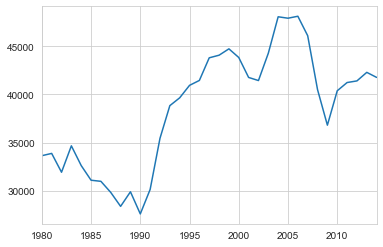

In [11]:
mdf5['year'].value_counts().sort_index().plot()

In [12]:
mdf5 = mdf5.sort_values(['permno', 'date'], ascending=True).set_index('date')

In [13]:
for var in ['compeqis2', 'mmt9','retonat11', 'netstkis1', 'accruals3',
              'netopat4', 'atgr5', 'invtoat6', 'o8', 'grpf10']:
    mdf5['ret'] = mdf5['r_t+36']
    regdf = mdf5[['jdate', 'permno', 'ticker', var, 'misp', 'ret']].replace([np.inf, -np.inf], np.nan).dropna()
    regdf[var] = (regdf[var] - regdf[var].mean()) / regdf[var].std()
    print(f'Ret 36m ~ {var}, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname=var, yname='ret'))
    print('')

Ret 36m ~ compeqis2, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.259995   0.010470  24.831325      0.024162  10.760340
compeqis2  420.0 -0.040317   0.002288 -17.622706      0.005056  -7.973474

Ret 36m ~ mmt9, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.251703   0.010673  23.583155      0.024686  10.196077
mmt9       420.0 -0.018172   0.003100  -5.862835      0.007085  -2.564777

Ret 36m ~ retonat11, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.253937   0.010713  23.704197      0.024779  10.248012
retonat11  420.0 -0.026991   0.002490 -10.841434      0.005502  -4.905598

Ret 36m ~ netstkis1, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.286964   0.010617  27.027575      0.024600  11.665422
netstkis1  420.0  0.013625   0.001553   8.775222      0.003559   3.82858

KeyboardInterrupt: 

In [ ]:
for var in ['compeqis2', 'mmt9','retonat11', 'netstkis1', 'accruals3',
              'netopat4', 'atgr5', 'invtoat6', 'o8', 'grpf10']:
    regdf = mdf5[['jdate', 'permno', 'ticker', var, 'misp']].replace([np.inf, -np.inf], np.nan).dropna()
    regdf[var] = (regdf[var] - regdf[var].mean()) / regdf[var].std()
    print(f'Misp ~ {var}, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname=var, yname='misp'))
    print('')

In [14]:
misp_scroe = pd.read_csv(f'{DATA_FOLDER}/Misp_Score.csv', index_col=0)
misp_scroe['date'] = pd.to_datetime(misp_scroe['yyyymm'], format='%Y%m') + MonthEnd(0)
misp_scroe['year'] = misp_scroe['date'].dt.year

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<AxesSubplot:>

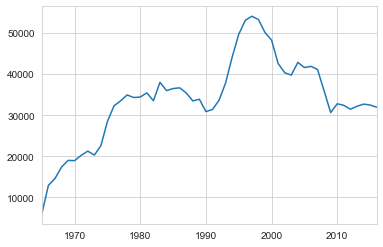

In [15]:
misp_scroe['year'].value_counts().sort_index().plot()

In [16]:
mdf5_with_score = mdf5.merge(misp_scroe, left_on=['jdate', 'permno'], right_on=['date', 'permno'], how='inner')
mdf5_with_score['ret'] = mdf5_with_score['r_t+60']
mdf5_with_score['ret_ct'] = mdf5_with_score['r*_t+60']-1
mdf5_with_score['ret_chg'] = mdf5_with_score['r_chg+60']
mdf5_with_score['avg_score'] = mdf5_with_score['avg_score']/mdf5_with_score['avg_score'].mean()

In [17]:
for m in [3, 6, 12, 24, 36, 48, 60]:
    mdf5_with_score['ret'] = mdf5_with_score[f'r_t+{m}'] # convert log ret to cum ret
    regdf = mdf5_with_score[['jdate', 'permno', 'ticker', 'ret', 'avg_score']].replace([np.inf, -np.inf], np.nan).dropna()
    print(f'{m}-Month Return, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname='avg_score'))
    print('')

3-Month Return, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.061749   0.003566  17.316938      0.005603  11.020132
avg_score  420.0 -0.051126   0.003195 -16.001567      0.005610  -9.113376

6-Month Return, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.116622   0.004771  24.446231      0.009391  12.418090
avg_score  420.0 -0.096757   0.004959 -19.510274      0.010435  -9.272015

12-Month Return, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.207517   0.006605  31.415837      0.014367  14.443890
avg_score  420.0 -0.175083   0.007647 -22.894978      0.017317 -10.110496

24-Month Return, 5Yr-DCF
           count     mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.37260   0.008495  43.861730      0.019319  19.286571
avg_score  420.0 -0.31635   0.009896 -31.968243      0.022896 -13.816883

36-Month Retu

In [18]:
mdf5_with_score['ret'] = mdf5_with_score['r_t+36']
for var in ['misp', 'ret', 'ret_ct', 'ret_chg']:
    regdf = mdf5_with_score[['jdate', 'permno', 'ticker', var, 'avg_score']].replace([np.inf, -np.inf], np.nan).dropna()
    print(f'{var} ~ Misp Score, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname='avg_score', yname=var))
    print('')

misp ~ Misp Score, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw  tstat_nw
alpha_i_t  420.0  0.401111   0.024474  16.388956      0.057653  6.957342
avg_score  420.0 -0.112446   0.014086  -7.982555      0.032228 -3.489095

ret ~ Misp Score, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.522014   0.010740  48.602951      0.024903  20.961972
avg_score  420.0 -0.437097   0.012149 -35.979073      0.028439 -15.369881

ret_ct ~ Misp Score, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw  tstat_nw
alpha_i_t  420.0 -1.081426   0.065794 -16.436584      0.157549 -6.864084
avg_score  420.0  0.001132   0.018311   0.061815      0.043006  0.026320

ret_chg ~ Misp Score, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw  tstat_nw
alpha_i_t  420.0  0.293149   0.068382   4.286956      0.163813  1.789533
avg_score  420.0  0.290862   0.021597  13.467464      0.051011  5.701970



In [19]:
mdf5_with_score['ret'] = mdf5_with_score['r_t+36']
for var in ['ret', 'avg_score']:
    regdf = mdf5_with_score[['jdate', 'permno', 'ticker', var, 'misp']].replace([np.inf, -np.inf], np.nan).dropna()
    print(f'{var} ~ Misp, 5Yr-DCF')
    print(fama_macbeth_reg_panel_nw(regdf, xname='misp', yname=var))
    print('')

ret ~ Misp, 5Yr-DCF
           count      mean  std_error      tstat  std_error_nw   tstat_nw
alpha_i_t  420.0  0.332629   0.011543  28.817204      0.027184  12.236198
misp       420.0 -0.179313   0.003796 -47.232722      0.009051 -19.811937

avg_score ~ Misp, 5Yr-DCF
           count      mean  std_error        tstat  std_error_nw    tstat_nw
alpha_i_t  420.0  0.971961   0.000856  1136.010449      0.002000  486.095118
misp       420.0 -0.003118   0.000478    -6.520741      0.001103   -2.825990



In [20]:
# %matplotlib notebook

<IPython.core.display.Javascript object>


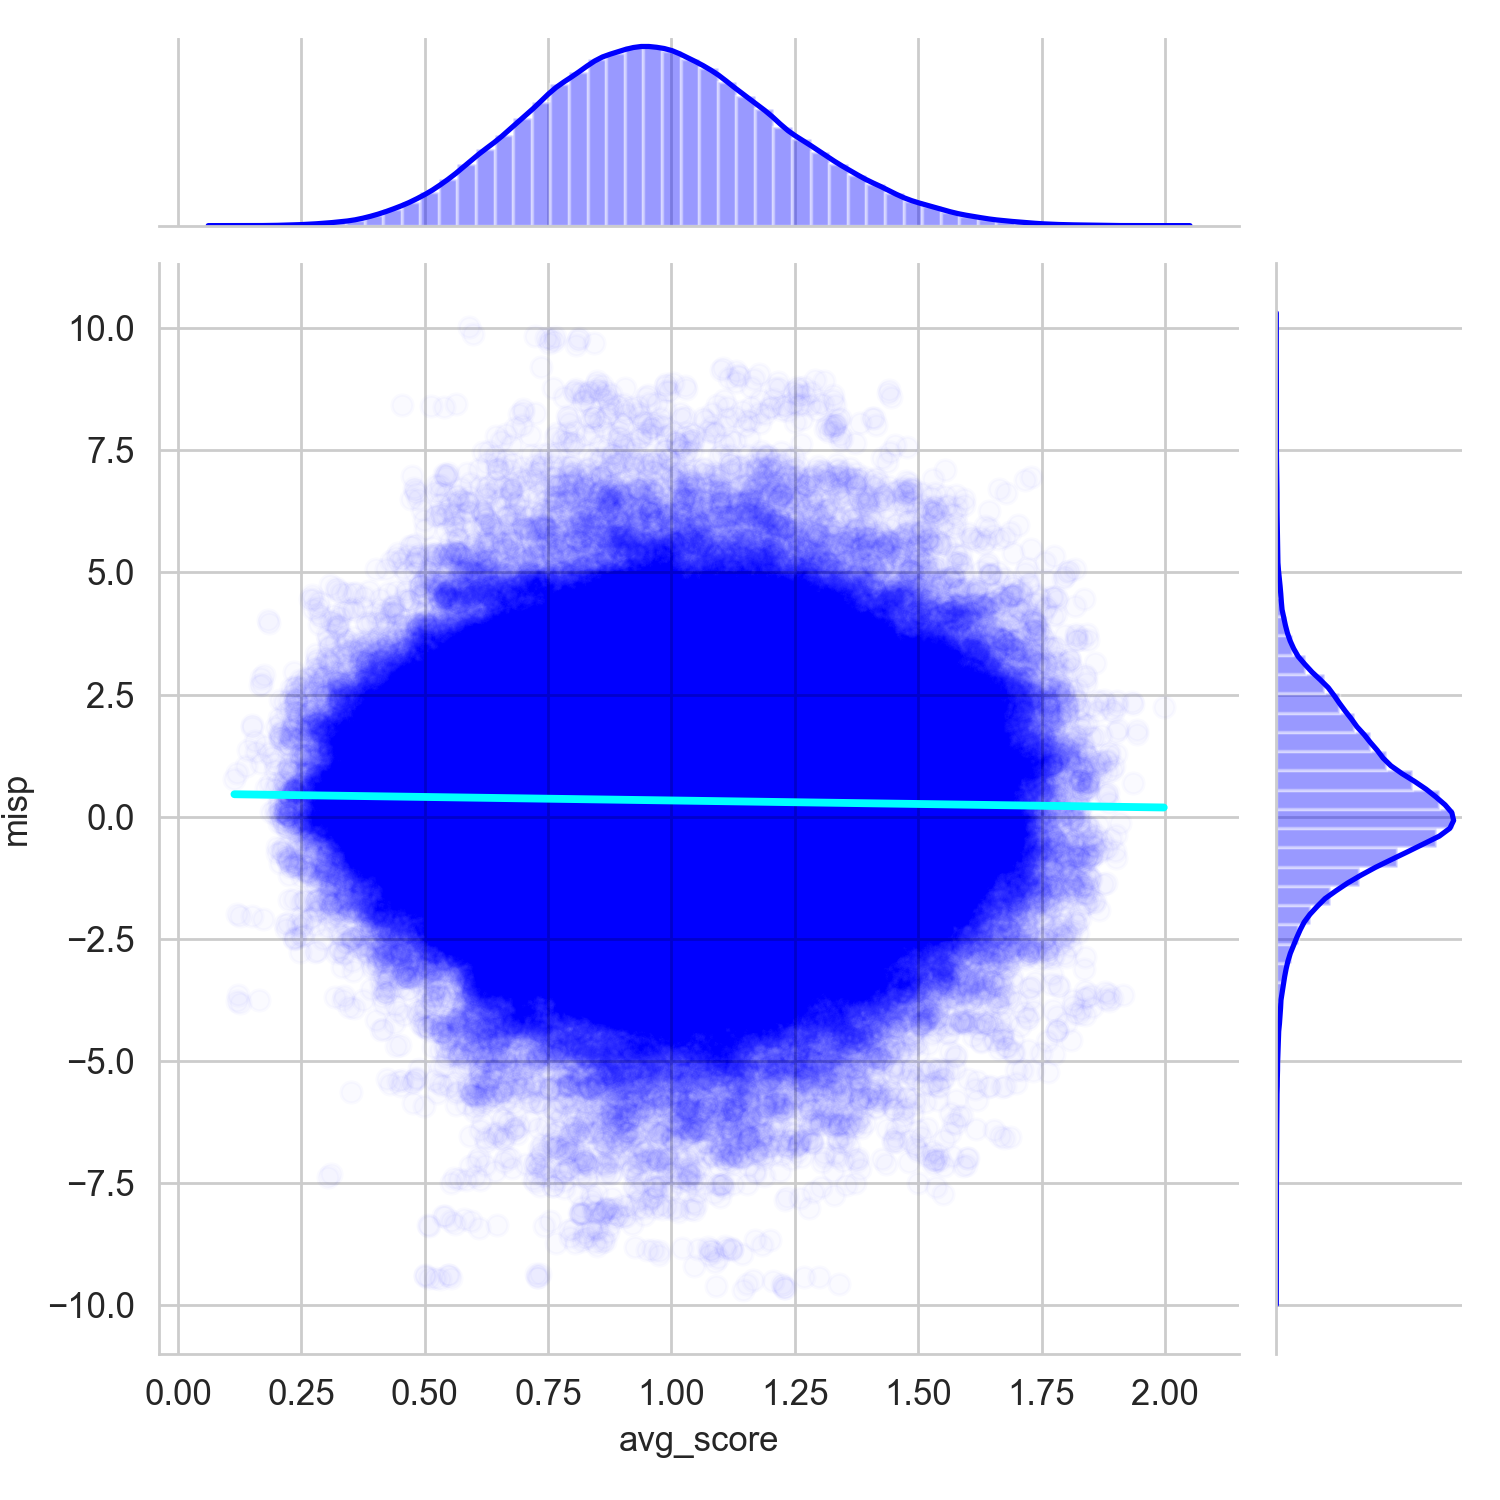

In [26]:
import matplotlib.cm as cm
# Calculate the point density
x=mdf5_with_score['avg_score']
y=mdf5_with_score['misp']
sns.jointplot(x, y ,color='blue', kind="reg",joint_kws = {'scatter_kws':dict(alpha=0.02),
                                                         'line_kws':{'color':'cyan'}})
plt.show()

<IPython.core.display.Javascript object>


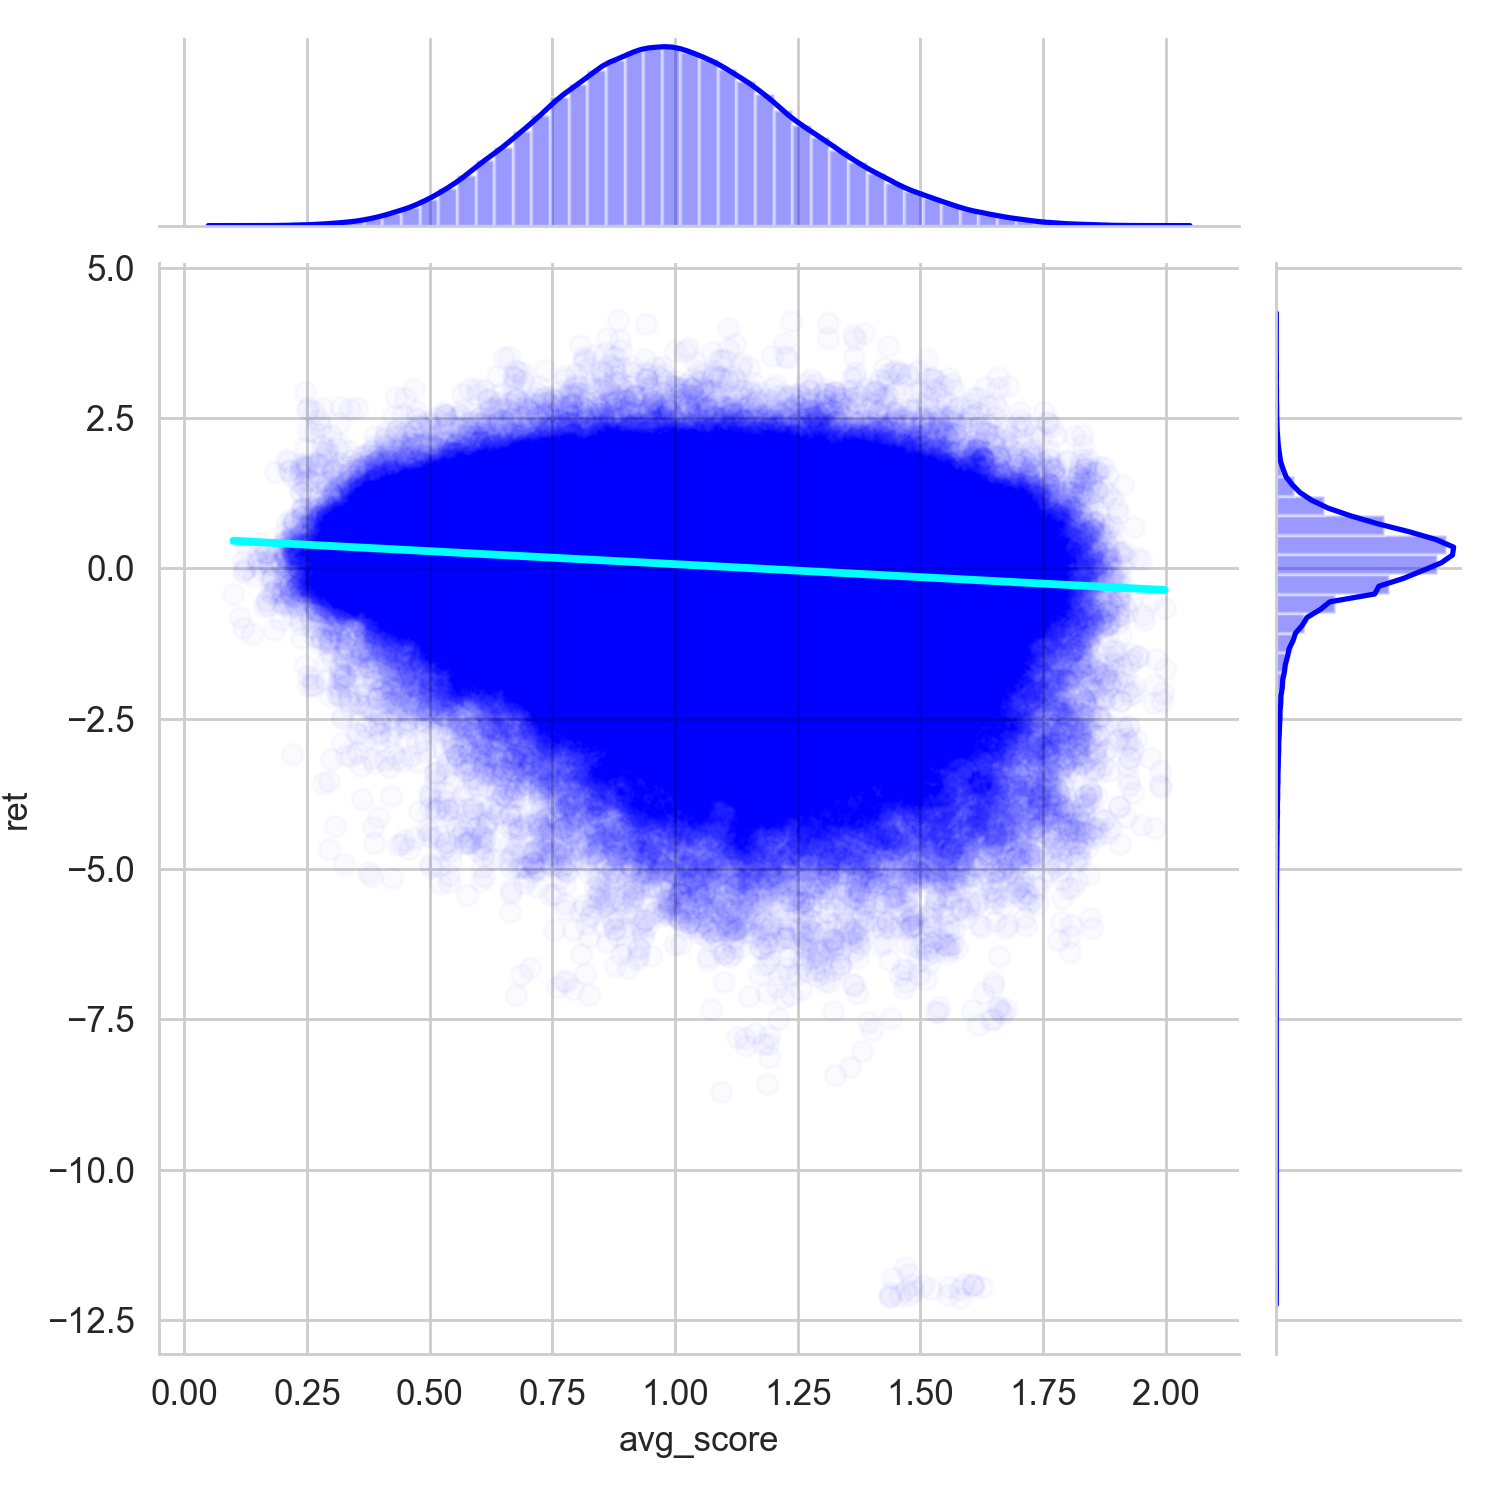

In [27]:
import matplotlib.cm as cm
# Calculate the point density
from scipy import stats
x=mdf5_with_score['avg_score']
y=mdf5_with_score['ret']

sns.jointplot(x, y ,color='blue', kind="reg", joint_kws = {'scatter_kws':dict(alpha=0.02),
                                                           'line_kws':{'color':'cyan'}})
plt.show()